Importing all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading the given dataset

In [ ]:
db = pd.read_csv("/content/drive/My Drive/spam.csv")

In [ ]:
db.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Encoding numerically using pandas

In [ ]:
db = db.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
db = db.rename(columns={'v1':'label','v2':'Text'})
db['label_enc'] = db['label'].map({'ham':0,'spam':1})
db.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Visulizing the given dataset

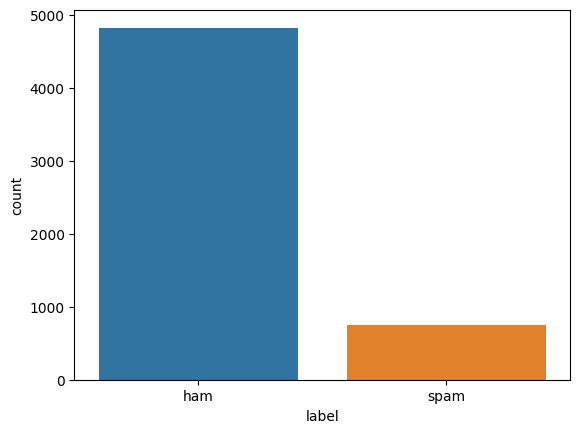

In [ ]:
sns.countplot(x=db['label'])
plt.show()

Finding the average number of tokens in all sentences

In [ ]:
avg_words_len=round(sum([len(i.split()) for i in db['Text']])/len(db['Text']))
print(avg_words_len)

15


Finding the total number of unique words in corpus

In [ ]:
s = set()
for sent in db['Text']:
  for word in sent.split():
	  s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


Splitting data for training and testing

In [ ]:
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(db['Text']), np.asanyarray(db['label_enc'])
new_db = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_db['Text'], new_db['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [ ]:
from tensorflow.keras.layers import TextVectorization
from keras import layers

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [ ]:
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN
)


Model 1

In [ ]:
from tensorflow import keras
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
	'''
	simply compile the model with adam optimzer
	'''
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
			X_test=X_test, y_test=y_test):
	'''
	fit the model with given epochs, train
	and test data
	'''
	history = model.fit(X_train,
						y_train,
						epochs=epochs,
						validation_data=(X_test, y_test),
						validation_steps=int(0.2*len(X_test)))
	return history

def evaluate_model(model, X, y):
	'''
	evaluate the model and returns accuracy,
	precision, recall and f1-score
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict

Model 2

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model

Epoch 1/5
140/140 [==============================] - 27s 116ms/step - loss: 0.1636 - accuracy: 0.9453 - val_loss: 0.0786 - val_accuracy: 0.9794
Epoch 2/5
140/140 [==============================] - 15s 106ms/step - loss: 0.0229 - accuracy: 0.9937 - val_loss: 0.0814 - val_accuracy: 0.9821
Epoch 3/5
140/140 [==============================] - 13s 96ms/step - loss: 0.0087 - accuracy: 0.9978 - val_loss: 0.0937 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 12s 86ms/step - loss: 7.9788e-04 - accuracy: 1.0000 - val_loss: 0.1419 - val_accuracy: 0.9785
Epoch 5/5
140/140 [==============================] - 14s 101ms/step - loss: 3.8170e-05 - accuracy: 1.0000 - val_loss: 0.1507 - val_accuracy: 0.9794


<Axes: >

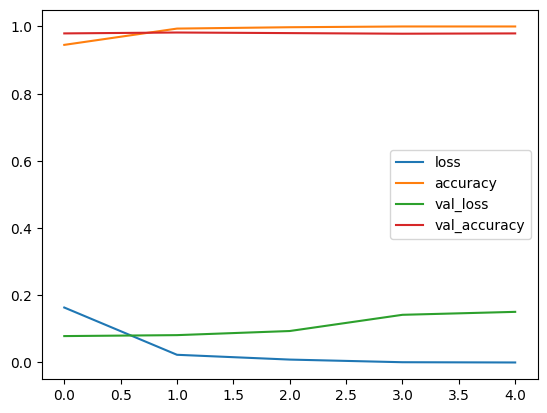

In [ ]:
pd.DataFrame(history_2.history).plot()

Model 3

In [ ]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 8s 35ms/step - loss: 0.2808 - accuracy: 0.9208 - val_loss: 0.1090 - val_accuracy: 0.9695
Epoch 2/5
140/140 [==============================] - 5s 35ms/step - loss: 0.0777 - accuracy: 0.9785 - val_loss: 0.0705 - val_accuracy: 0.9749
Epoch 3/5
140/140 [==============================] - 3s 23ms/step - loss: 0.0557 - accuracy: 0.9836 - val_loss: 0.0585 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 4s 31ms/step - loss: 0.0468 - accuracy: 0.9868 - val_loss: 0.0539 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 3s 25ms/step - loss: 0.0402 - accuracy: 0.9879 - val_loss: 0.0520 - val_accuracy: 0.9821


<Axes: >

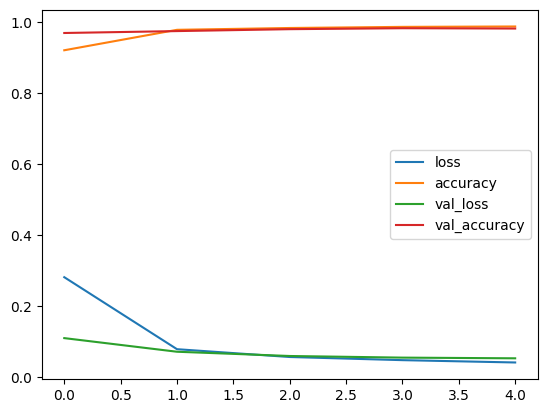

In [ ]:
pd.DataFrame(history_3.history).plot()

Summary

In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
							'Custom-Vec-Embedding Model':model_1_results,
							'Bidirectional-LSTM Model':model_2_results,
							'USE-Transfer learning Model':model_3_results}).transpose()

total_results

35/35 [==============================] - 1s 12ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.118386,0.105960,0.746667,0.185584
Bidirectional-LSTM Model,0.979372,0.977444,0.866667,0.918728
USE-Transfer learning Model,0.982063,0.964286,0.900000,0.931034
